In [0]:
import json
import torch
import re
import numpy as np
import collections

from torch import nn
from torch.optim import SGD, Adam
from google.colab import files, auth, drive
from urllib.request import urlopen
from typing import List, Dict, Callable
from collections import Counter
from os import path
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
drive.mount('/content/gdrive')

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


In [0]:
'''=================================  DEFINES  ================================='''

'''======= Paths ======='''

TrainPath = "gdrive/My Drive/Datasets/Emoji/demojized_train.txt"
TestPath = "gdrive/My Drive/Datasets/Emoji/demojized_dev.txt"


In [0]:
'''=================================  EXTERNAL FUNCTIONS  ================================='''


def readfile(filepath: str) -> str:
    """
    Reads file and returns its content as a string.
    """
    #response = urlopen(url)
    #body = response.read().decode('utf-8')
    with open(filepath, "r") as f:
        body = f.read()
    
    return body.encode('ascii', 'ignore').decode("utf-8")


# Used with regex

def find_all(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1: return
        yield start
        start += len(sub) 
  

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

In [0]:
'''================================= CUSTOM DATA-STRUCTURES  ================================='''

#Mostly pentru label-uri
class TwoWayDict():
  
  def __init__(self,):
    self.to_number = collections.OrderedDict()
    self.to_language = collections.OrderedDict()
    

    
  def insert(self,word):
    if not word in self.to_number:
      new_index = len(self.to_number)
      self.to_number[word] = new_index
      self.to_language[new_index] = word
    
    
  def getindex(self,word):
    return self.to_number[word]
  
  def getlabel(self,label):
    return self.to_language[label]
  
  def getlabellist(self):
    label_list = []
    for label,value in self.to_language.items():
      label_list.append(value)
    
    return label_list

  
#  Pentru vocabular de tip char  
class Vocabulary:
    """
    Helper class that maps characters to unique indices and the other way around
    """
    def __init__(self, text: str):
        #special character for padding shorter sequences in a mini-batches
        characters_set = set("©") 
        characters_set.update(text)

        
        self.char_to_idx = {char:idx for (idx, char) 
                            in enumerate(characters_set)}
        
       
        self.idx_to_char = {idx:char for (idx, char) 
                            in enumerate(characters_set)}
   
    def size(self):
        return len(self.char_to_idx)
      
    def __str__(self):
        return str(self.char_to_idx)
  
  
def text_to_tensor(text: str, vocab: Vocabulary) -> torch.LongTensor:
    """
    Convert a string to a Tensor with corresponding character indices
    e.g. "We have" -> [12, 6, 20, 13, 1, 25, 6] 
    """
    
    
    text_indices = [vocab.char_to_idx[c] for c in text]
    
    return torch.tensor(text_indices)  

  
def tensor_to_text(x: torch.LongTensor, vocab: Vocabulary) -> str:
    """
    Convert a Tensor of character indices to its string representation
    e.g. [12, 6, 20, 13, 1, 25, 6] -> "We have"
    """
    
    x = x.cpu().detach().numpy()
    
    for elem in x :
      print(vocab.idx_to_char[elem],sep='')

  
def get_vocabulary(trainPath : str):
    
    text = readfile(trainPath)
    
    vocab = Vocabulary(text)
    
    return vocab


    




In [0]:
'''=================================   GLOVE EMBEDDING  ================================='''

'''====== Load Glove Model======'''

def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

  
'''====== Get Word Embeddings ======'''

def get_value(word,gloveModel):
  answer = torch.zeros(100,dtype=torch.float64)  
  if word in gloveModel.keys():
    answer = answer + torch.tensor(gloveModel[word],dtype=torch.float64)  
  return answer


def get_tensor_form(phrase,gloveModel):  
  
  phrase_tensor = get_value(phrase[0],gloveModel)
  for i in range(1,len(phrase)):
    phrase_tensor += get_value(phrase[i], gloveModel)

  return phrase_tensor  
  
  
  
'''====== Instantiate Glove Model ======'''
  
  
#glovePath = "gdrive/My Drive/Datasets/Emoji/glove.twitter.27B.100d.txt"
#gloveModel = loadGloveModel(glovePath)

'====== Instantiate Glove Model ======'

In [0]:
def cut_phrase(phrase, max_length):

  
  phrase_bounds = list(find_all(phrase, '<end>'))

  leftsentence = ""
  middlesentence = ""
  rightsentence = ""
        
  for i in range(phrase_bounds[0],phrase_bounds[1]):
    leftsentence = leftsentence + phrase[i]
  
  for i in range(phrase_bounds[1],phrase_bounds[2]):
    middlesentence = middlesentence + phrase[i]

  for i in range(phrase_bounds[2],phrase_bounds[3]):
    rightsentence = rightsentence + phrase[i]

  
  l1 = len(leftsentence)
  l2 = len(middlesentence)
  l3 = len(rightsentence)
  
  '''
  -8 deoarece de la ultima se taie fix <end> si vrem sa adaugam si un spatiu
  de asemenea se modifica cea din mijloc si la stanga si la dreapta
  '''
  
  while(l1+l2+l3 > max_length - 8):
    
    if(l1 >= l2 and l1 >= l3):
      leftsentence = leftsentence[:-1]
      l1 -= 1
    elif(l2 >= l1 and l2 >= l3):
      middlesentence = middlesentence[:-1]
      l2 -= 1
    else:
      rightsentence = rightsentence[:-1]
      l3 -= 1
    
  middlesentence = " " + middlesentence + " "
  rightsentence = rightsentence + " <end>"
  
  #print(leftsentence)
    
  return leftsentence + middlesentence + rightsentence  


In [0]:
'''=================================   DATA LOADING  ================================='''
def get_data(path : str,  label_dict: TwoWayDict):
  print(path)
  labelcounter = 0
  words = []
  labels = []
  with open(path) as file:
    cnt = 0 
    for line in file:
      if cnt > 0:
        label = line.split()[-1]
        
        labels.append(label)
        
        templine = line.split(' ')[1:-1]
        
        words.append(templine)

        label_dict.insert(label)

      cnt+=1
  
  return [words,labels]
  
  
  
def get_dataset_loader(words, labels, label_dict, vocabulary, max_length=95,max_batch_idx=100, shuffle=True):
  
  dataset_length = len(labels)

  traintensor = torch.zeros(dataset_length,max_length + 3) # Cele 3 hidden state-uri pe care le cautam :)
  labeltensor = torch.zeros(dataset_length,1)
  
  padding_tensor = torch.tensor([vocabulary.char_to_idx["©"]])
  
  for i in range(0, dataset_length):

    
    phrase = words[i]
    currentlabel = labels[i]  
    
    phrase = ' '.join(phrase)
    
    if(len(phrase) > max_length):
      phrase = cut_phrase(phrase,max_length)
    
    hidden_state_positions = []
    
    
    hidden_state_positions = list(find_all(phrase, '<end>'))
    hidden_state_positions = [x+4 for x in hidden_state_positions]
    hidden_state_positions.pop(0) # delete the first <end>
    
    
    #print(hidden_state_positions)
    #print(phrase)
    
    phrase = text_to_tensor(phrase,vocabulary)
    
    while(phrase.size()[0] < max_length):
      phrase = torch.cat((phrase,padding_tensor))
    
    currentlabel = label_dict.getindex(currentlabel)

    
    hidden_state_positions = torch.tensor(hidden_state_positions)
    #print(hidden_state_positions)
    
    phrase = torch.cat((phrase,hidden_state_positions))
    phrase = phrase.to(device)
    
    #print(phrase.size())
    
    newlabel = torch.zeros(1).to(device).long()
    newlabel[0]=currentlabel
    currentlabel = newlabel

    traintensor[i] = phrase
    labeltensor[i] = currentlabel
    
  
  large_dataset = TensorDataset(torch.tensor(traintensor).to(device), torch.tensor(labeltensor).to(device))
  large_data_loader = DataLoader(large_dataset, batch_size=max_batch_idx, shuffle=True, drop_last=True)
  return large_data_loader

In [62]:
label_dict = TwoWayDict()
vocab = get_vocabulary(TrainPath)

[trainingwords,traininglabels] = get_data(TrainPath,label_dict)
data_loader_train = get_dataset_loader(trainingwords,traininglabels,label_dict, vocab, _hyperparameters_dict['max_len'], _hyperparameters_dict['batch_size'])

[testingwords,testinglabels] = get_data(TestPath,label_dict)
data_loader_test  = get_dataset_loader(testingwords,testinglabels,label_dict, vocab, _hyperparameters_dict['max_len'], _hyperparameters_dict['batch_size'])

'''
Am testat sa vad daca datele sunt create in mod corespunzator

for batch_idx, (data, target) in enumerate(data_loader_test):
  hidden_states_indexes = data[:,_hyperparameters_dict['max_len']:_hyperparameters_dict['max_len']+3]
  data = data[:,0:_hyperparameters_dict['max_len']]
  text = tensor_to_text(data[0,:],vocab)
  break
'''
    

gdrive/My Drive/Datasets/Emoji/demojized_train.txt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


gdrive/My Drive/Datasets/Emoji/demojized_dev.txt


"\nAm testat sa vad daca datele sunt create in mod corespunzator\n\nfor batch_idx, (data, target) in enumerate(data_loader_test):\n  hidden_states_indexes = data[:,_hyperparameters_dict['max_len']:_hyperparameters_dict['max_len']+3]\n  data = data[:,0:_hyperparameters_dict['max_len']]\n  text = tensor_to_text(data[0,:],vocab)\n  break\n"

In [0]:
'''=================================  NETWORK DEFINITION  ================================='''

class RNNLM(nn.Module):
    def __init__(self, vocab_size: int, char_embedding_size: int,
                 rnn_size: int, final_output_size:int):
        super().__init__()

        self.vocab_size = vocab_size
        self.char_embedding_size = char_embedding_size
        self.rnn_size = rnn_size

        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=char_embedding_size)

        self.rnn_cell = nn.LSTMCell(input_size=char_embedding_size,
                                   hidden_size=rnn_size)
        
        self.rrn_cell_reverse = nn.LSTMCell(input_size=char_embedding_size,
                                   hidden_size=rnn_size)
        
        
        self.logits = nn.Linear(in_features=rnn_size*2, out_features=final_output_size)
        
        self.loss = nn.CrossEntropyLoss()
        

    def get_loss(self, logits: torch.FloatTensor, y: torch.FloatTensor):

        y = y.view(-1)
      
      
        #print(logits.size())
      
        return self.loss(logits, y)

    def get_logits(self, hidden_states: torch.FloatTensor,hidden_states_reverse : torch.FloatTensor, hidden_states_indexes,
                   temperature: float = 1):
      
        max_len = hidden_states.size(1)
        answer = torch.cat((hidden_states[:,-1,:],hidden_states_reverse[:,-1,:]),dim=1).to(device)
        

        
        return self.logits(answer)        
        

    def forward(self, x: torch.LongTensor,
                hidden_start: torch.FloatTensor = None, cell_start : torch.FloatTensor = None,hidden_start_reverse : torch.FloatTensor = None, cell_start_reverse : torch.FloatTensor = None) -> torch.FloatTensor:


        max_len = x.size(1)

        x_embedded = self.embedding(x)

        hidden_states_list = []
        hidden_states_list_reverse = []
        
        prev_hidden = hidden_start
        prev_cell = cell_start
       
        prev_hidden_reverse = hidden_start_reverse
        prev_cell_reverse = cell_start_reverse
        
        
        
        for t in range(max_len):

            hidden_state,hidden_cell = self.rnn_cell(x_embedded[:, t, :], (prev_hidden,prev_cell))
            hidden_states_list.append(hidden_state)

            prev_hidden = hidden_state
            prev_cell = hidden_cell

        hidden_states = torch.stack(hidden_states_list, dim=1).to(device)
        
        
        for t in range(max_len):

            hidden_state_reverse,hidden_cell_reverse = self.rrn_cell_reverse( x_embedded[:,max_len-t-1,:], (prev_hidden_reverse,prev_cell_reverse))
            hidden_states_list_reverse.append(hidden_state_reverse)            
            
            prev_hidden_reverse = hidden_state_reverse
            prev_cell_reverse = hidden_cell_reverse
        
        hidden_states_reverse = torch.stack(hidden_states_list_reverse,dim=1).to(device)
        
        
        return [hidden_states,hidden_states_reverse]

In [0]:
'''=================================  RUN THE TRAINING / TESTING  ================================='''

def trainRNNM(model, device, train_loader, optimizer, epoch, verbose):
    
    model.train()
    
    prev_hidden = torch.zeros(_hyperparameters_dict["batch_size"],_hyperparameters_dict["rnn_size"]).to(device)
    cell_hidden = torch.zeros(_hyperparameters_dict["batch_size"],_hyperparameters_dict["rnn_size"]).to(device)
    
    prev_hidden_reverse = torch.zeros(_hyperparameters_dict["batch_size"],_hyperparameters_dict["rnn_size"]).to(device)
    cell_hidden_reverse = torch.zeros(_hyperparameters_dict["batch_size"],_hyperparameters_dict["rnn_size"]).to(device)

    for batch_idx, (data, target) in enumerate(train_loader):
      
      
        hidden_states_indexes = data[:,_hyperparameters_dict['max_len']:_hyperparameters_dict['max_len']+3]
        
        # Fac asta deoarece in ultimile 3 valori din sample-ul ales sunt de fapt hidden-state-urile care corespund cuvintelor : <end>.
        # Asta doar ca sa nu imi fac functia proprie ptr get_batch_sample. reusing code ftw
        data = data[:,0:_hyperparameters_dict['max_len']]
        data = data.to(device)
      
        data = data.type(torch.LongTensor).to(device)
        target = target.type(torch.LongTensor).to(device)
        hidden_states_indexes = hidden_states_indexes.type(torch.LongTensor).to(device)
        
        optimizer.zero_grad()

        [hidden_states,hidden_states_reverse] = model(data,prev_hidden,cell_hidden,prev_hidden_reverse,cell_hidden_reverse)        
        logits = model.get_logits(hidden_states,hidden_states_reverse,hidden_states_indexes)        
        loss = model.get_loss(logits,target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(list(model.parameters()), 5.0)

        optimizer.step()

        hidden_states.detach()
        hidden_states_reverse.detach()

        if batch_idx % verbose == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            # plot_loss(loss.cpu().detach().numpy(),label='train')

            
def testRNNM(model, device, test_loader,verbose):
    model.eval()
    test_loss = 0
    correct = 0
    
    ground_truth_array = []
    prediction_array = []
    

    prev_hidden = torch.zeros(_hyperparameters_dict["batch_size"],_hyperparameters_dict["rnn_size"]).to(device)
    cell_hidden = torch.zeros(_hyperparameters_dict["batch_size"],_hyperparameters_dict["rnn_size"]).to(device)
    
    
    prev_hidden_reverse = torch.zeros(_hyperparameters_dict["batch_size"],_hyperparameters_dict["rnn_size"]).to(device)
    cell_hidden_reverse = torch.zeros(_hyperparameters_dict["batch_size"],_hyperparameters_dict["rnn_size"]).to(device)
    
    with torch.no_grad():
        for batch_idx,(data, target) in enumerate(test_loader):
            
            hidden_states_indexes = data[:,_hyperparameters_dict['max_len']:_hyperparameters_dict['max_len']+3]
            
            # Fac asta deoarece in ultimile 3 valori din sample-ul ales sunt de fapt hidden-state-urile care corespund cuvintelor : <end>.
            # Asta doar ca sa nu imi fac functia proprie ptr get_batch_sample. reusing code ftw
            data = data[:,0:_hyperparameters_dict['max_len']]
            data = data.type(torch.LongTensor).to(device)

            
            
            
            target = target.type(torch.LongTensor).to(device)
            hidden_states_indexes = hidden_states_indexes.type(torch.LongTensor).to(device)

            [hidden_states,hidden_states_reverse] = model(data,prev_hidden,cell_hidden,prev_hidden_reverse,cell_hidden_reverse)        
            logits = model.get_logits(hidden_states,hidden_states_reverse,hidden_states_indexes)        
            loss = model.get_loss(logits,target)


            hidden_states.detach()

            test_loss += loss
            pred = logits.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            prediction_array.extend(pred.view(-1)[:].cpu().numpy())
            ground_truth_array.extend(target[:].cpu().numpy())
          
            

   
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    #plot_loss(test_loss,label='test',color='red')
    
        
    print(classification_report(ground_truth_array, prediction_array, target_names=label_dict.getlabellist()))
    
    
    print('\n')
    
    plot_confusion_matrix(ground_truth_array, prediction_array, classes=label_dict.getlabellist(),
                      title='Confusion matrix')
    
            

In [0]:
##'''=================================  HYPERPARAMETERS  ================================='''

_hyperparameters_dict = {
    "batch_size": 32,
    "num_epochs": 1000,
    "max_len": 200,
    "embedding_size": 100,
    "rnn_size": 512,
    "learning_algo": "adam",
    "learning_rate": 0.001,
    "output_size" : 4,
    "max_grad_norm": 5.0
}


['others', 'angry', 'sad', 'happy']
Train Epoch: 1 [0/30160 (0%)]	Loss: 1.368362
Train Epoch: 1 [3200/30160 (11%)]	Loss: 1.352873
Train Epoch: 1 [6400/30160 (21%)]	Loss: 1.255577
Train Epoch: 1 [9600/30160 (32%)]	Loss: 1.238833
Train Epoch: 1 [12800/30160 (42%)]	Loss: 1.086609
Train Epoch: 1 [16000/30160 (53%)]	Loss: 1.179838
Train Epoch: 1 [19200/30160 (64%)]	Loss: 1.252464
Train Epoch: 1 [22400/30160 (74%)]	Loss: 1.070655
Train Epoch: 1 [25600/30160 (85%)]	Loss: 1.305633
Train Epoch: 1 [28800/30160 (96%)]	Loss: 1.083782

Test set: Average loss: 0.0239, Accuracy: 2286/2755 (83%)

              precision    recall  f1-score   support

      others       0.86      0.97      0.91      2337
       angry       0.23      0.03      0.06       150
         sad       0.00      0.00      0.00       125
       happy       0.23      0.18      0.20       140

   micro avg       0.83      0.83      0.83      2752
   macro avg       0.33      0.29      0.29      2752
weighted avg       0.76      0.8

KeyboardInterrupt: ignored

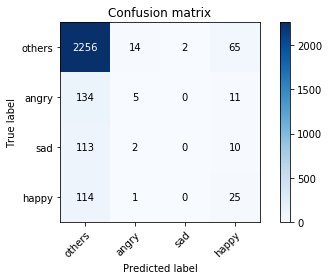

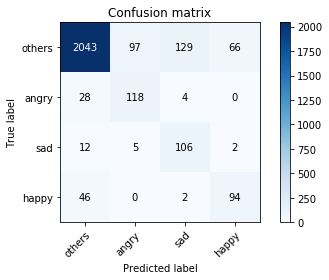

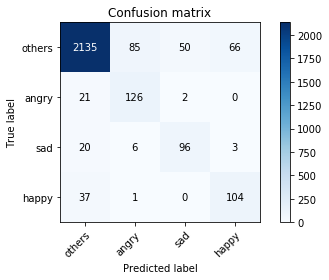

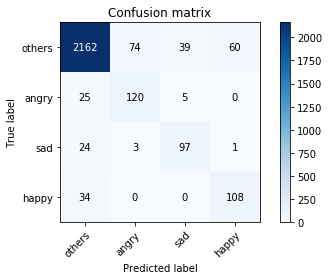

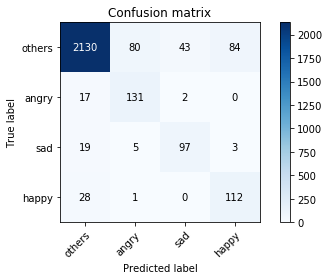

In [114]:
'''=================================  RUN THE TRAINING / TESTING  ================================='''

network= RNNLM(vocab.size(),_hyperparameters_dict['embedding_size'], _hyperparameters_dict['rnn_size'], _hyperparameters_dict['output_size'])
network = network.to(device)

epochs = _hyperparameters_dict['num_epochs']
verbose = 100


optimizer = torch.optim.Adam(network.parameters(),lr=_hyperparameters_dict['learning_rate'])

print(label_dict.getlabellist())
for epoch in range(1, epochs):
    trainRNNM(network,device,data_loader_train,optimizer,epoch, verbose)
    testRNNM(network, device, data_loader_test, verbose)
  

In [0]:
for batch_idx,(data,target) in enumerate(data_loader_train):
  print(data)

In [0]:
for batch_idx,(data,target) in enumerate(data_loader_test):
  print(data)

In [0]:
import torch
x = torch.LongTensor([[[3, 4, 1], [8, 1, 6]], [[7,2,3], [5,3,8]]])
print(x)

tensor([[[3, 4, 1],
         [8, 1, 6]],

        [[7, 2, 3],
         [5, 3, 8]]])


In [0]:
torch.max(x, 1)

(tensor([[8, 4, 6],
         [7, 3, 8]]), tensor([[1, 0, 1],
         [0, 1, 1]]))